In [ ]:
import os
import numpy as np
import glob
import tensorflow as tf
from keras.models import Sequential
import pathlib
import keras
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
import matplotlib.cm as cm

In [ ]:
# Mounting the Google Drive to the Colab environment
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cnn_fine_tuned = load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/conv_model_tuned.h5')

# Print model summary to see layer names
cnn_fine_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 34, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

# IMPORTANCE OF GRAD-CAM VISUALIZATION

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique that is used to understand which parts of an image are most important for a deep learning model's predictions. The technique works by generating a heatmap that highlights the regions of the image that the model is most sensitive to when making a prediction.

There are several reasons why Grad-CAM visualization can be important:

- Model understanding: Grad-CAM visualization can be useful for understanding how a deep learning model is making its predictions. By highlighting the regions of the image that are most important for the model's predictions, Grad-CAM can help to provide insight into the decision-making process of the model.

- Model debugging: Grad-CAM visualization can also be useful for debugging problems with a deep learning model. For example, if the model is making incorrect predictions, Grad-CAM can help to identify which parts of the image the model is focusing on and potentially identify any issues with the model's training or architecture.

- Model explanation: Grad-CAM visualization can be useful for explaining the predictions of a deep learning model to non-technical stakeholders. By highlighting the regions of the image that are most important for the model's predictions, Grad-CAM can provide a more intuitive understanding of the model's decision-making process.

# Multiple Image

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size = size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
image_folder = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Test_Images/"

# Use glob to get a list of all image files in the folder
image_paths = glob.glob(image_folder + "*.jpg")

covid_noncovid_heatmap = []

for i in image_paths:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 1s 1s/step


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(image_paths)):
    save_and_display_gradcam(image_paths[i], covid_noncovid_heatmap[i])

<ipython-input-45-b79ce8e1abfa>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):

    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)

    plt.show()

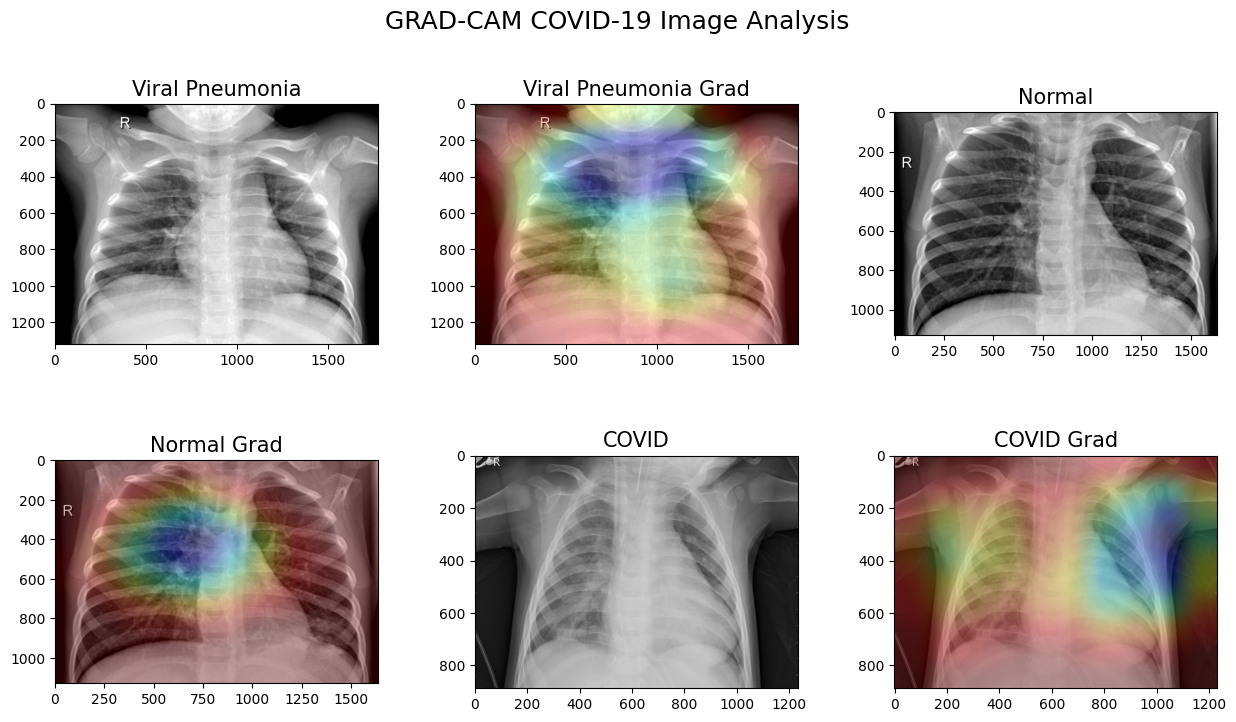

In [ ]:
titles_list = ["Viral Pneumonia",'Viral Pneumonia Grad','Normal','Normal Grad','COVID','COVID Grad']

plot_multiple_img(imag, titles_list, ncols = 3, main_title = "GRAD-CAM COVID-19 Image Analysis")

# Single Image

<ipython-input-59-d04642e3f473>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


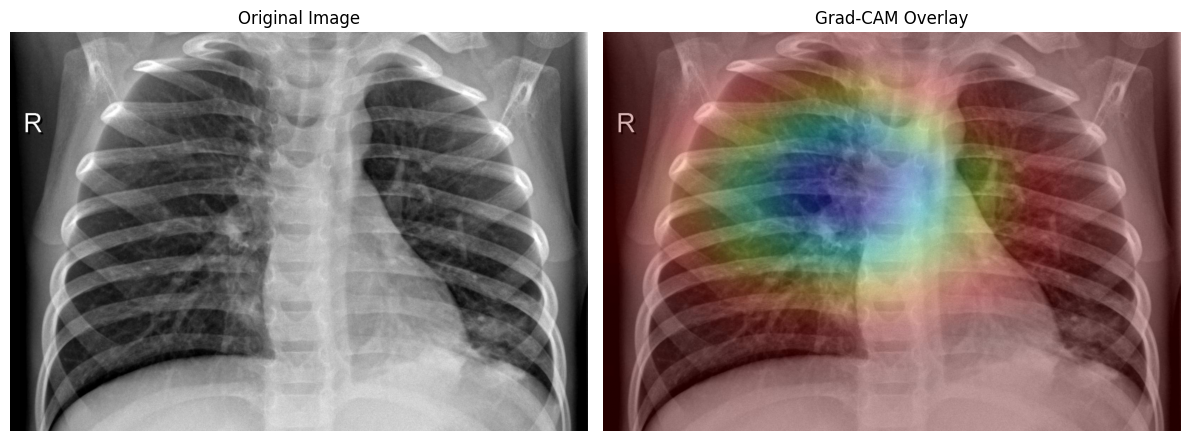

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
last_conv_layer_name = "block14_sepconv2_act"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size = size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    # Display the original image and the Grad-CAM overlay
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img / 255.0)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    cam = cv2.imread(cam_path)
    axes[1].imshow(cam / 255.0)
    axes[1].set_title('Grad-CAM Overlay')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Define your image path
image_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Test_Images/PNEUMONIA(4023).jpg"

# Load and preprocess the image
img_array = preprocess_input(get_img_array(image_path, size=img_size))

# Load the Xception model
model = model_builder(weights="imagenet")
model.layers[-1].activation = None

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Save and display the Grad-CAM
save_and_display_gradcam(image_path, heatmap)
